In [16]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline
# This blokc is important if we want the memory to grow on the GPU, and not block allocate the whole thing
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import os, glob
from pathlib import Path
import pandas as pd

# Hyperparam opt
import talos as ta
import numpy as np
from collections import defaultdict

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Set path to find modelling tools for later use
import sys
sys.path.append(os.path.join(os.getcwd(),".."))
# # Global params live here
# import haberrspd.charCNN.globals
# from haberrspd.charCNN.models_tf import char_cnn_model_talos
# from haberrspd.charCNN.data_utilities import create_training_data_keras
from haberrspd.postprocess_cnn_results import PostprocessTalos

# Plotting
from haberrspd.plotting import nice_fonts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import keras

In [58]:
keras.__version__

'2.2.4'

Text(0, 0.5, 'True Positive Rate')

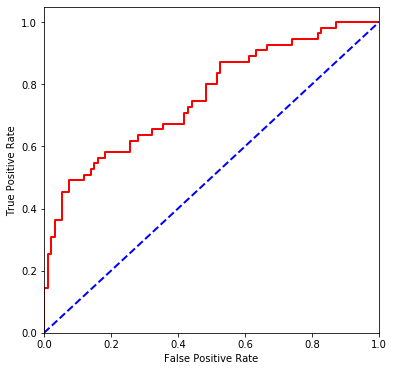

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
lw = 2
ax.plot(rocs['char_time_space'][0], rocs['char_time_space'][1], color="red", lw=lw)#, label="ROC curve (area = %0.2f)" % (1-auc))
ax.plot([0, 1], [0, 1], color="blue", lw=lw, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
# ax.set_title("Receiver Operating Curve")
# ax.legend(loc="lower right")

## Assign a loss function

In [ ]:
loss_func = 'squared_hinge'

if loss_func == 'hinge' or loss_func == 'squared_hinge':
    y_train = [-1 if x==0 else x for x in y_train]
    y_test = [-1 if x==0 else x for x in y_test]
    
if loss_func == 'binary_crossentropy':
    # Check if label-space is correct
    if (-1 in y_train) or (-1 in y_test):
        y_train = [0 if x==-1 else x for x in y_train]
        y_test = [0 if x==-1 else x for x in y_test]

## Train model

In [ ]:
# Compile
model.compile(loss=loss_func,  # TODO: change to cosine loss, cosine_proximity, binary_crossentropy
              optimizer='adam',            # TODO: check which is most appropriate
              metrics=['accuracy'])        # Probs other options here which are more useful

# Check if checkpoints dir exists, if not make it
if not os.path.exists('../../keras_checkpoints'):
    os.makedirs('../../keras_checkpoints')

# Callbacks
file_name = "char-CNN"
check_cb = ModelCheckpoint(file_name + '.{epoch:02d}-{val_loss:.2f}.hdf5',
                           monitor='val_loss',
                           verbose=0,
                           save_best_only=True,
                           mode='min')

earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=7,
                             verbose=0,
                             mode='auto')

# history = LossHistory()
"""
TODO:

-Add class-weight option to take into account class-imbalance on patients and controls
"""
fit_hist = model.fit(X_train,
                     y_train,
                     validation_data=(X_test, y_test),
                     verbose=0, # Set to zero if using live plotting of losses
                     class_weight = class_weights,
                     batch_size=128,
                     epochs=40,
                     #shuffle=True, # Our data is already shuffled during data loading
                     callbacks=[
                                #check_cb,
                                #tensorboard_callback,
                                PlotLossesCallback(),
                                #earlystop_cb
                               ]
                    )

# TALOS: hyperparameter optimisation

In [4]:
from haberrspd.charCNN.data_utilities import (create_training_data_keras,
                                              create_data_objects,
                                              english_language_qwerty_keyboard,
                                              us_keyboard_keys_to_2d_coordinates_mrc,
                                             )
import numpy as np
import itertools
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from collections import defaultdict

import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

---

In [5]:
DATA_ROOT = Path("../data/") / "MJFF" / "preproc"
X_train, X_test, y_train, y_test, max_sentence_length, alphabet_size = create_training_data_keras(
    DATA_ROOT, "char_time_space", "SpanishData-preprocessed.csv")

# Class weights are dynamic as the data-loader is stochastic and changes with each run.
class_weights = dict(zip([0, 1], class_weight.compute_class_weight("balanced", list(set(y_train)), y_train)))

Total number of characters used in all typed sentences: 54


In [6]:
X_test.shape

(144, 11100, 56)

In [15]:
del X_train, X_test, y_train, y_test

In [61]:
opt_params = {
    "lr": (0.1, 10, 5),  # This is a range not a tuple
    "conv_output_space": [8, 16, 32],  # ,8],
    "number_of_large_filters": [1, 2, 4],
    "number_of_small_filters": [1, 2, 4],
    "large_filter_length": [8, 16, 32],  # When time is included [20,40,80,160], when not: [10,20,40,80]
    "small_filter_length": [2, 4, 8],  # [5, 10, 20],
    "pool_length": [2, 4],
    "dense_units_layer_3": [32, 64],
    "dense_units_layer_2": [16, 32],
    "batch_size": [16, 32, 64],
    "epochs": [100, 200],
    "dropout": (0, 0.5, 5),
    "conv_padding": ["same"],
    "conv_kernel_initializer": ["uniform"],
    "conv_bias_initializer": ["uniform"],
    "dense_kernel_initializer": ["uniform"],
    "dense_bias_initializer": ["uniform"],
    "optimizer": [Adam, Nadam],  # If used this way, these have to explicitly imported
    "loss": ["logcosh", "binary_crossentropy"],  # Loss functions
    "conv_activation": ["relu"],
    "dense_activation": ["relu"],
    "last_activation": ["sigmoid"],
    # Stationary parameters, i.e. do not get optimised
    "max_sentence_length": [max_sentence_length],
    "alphabet_size": [alphabet_size],
    "control_class_weight": [class_weights[0]],
    "pd_class_weight": [class_weights[1]],
}

"""
'sgd': SGD,
'rmsprop': RMSprop,
'adagrad': Adagrad,
'adadelta': Adadelta,
'adam': Adam,
'adamax': Adamax,
'nadam': Nadam
"""

def size_of_optimisation_space(params):
    space = 1
    for attribute in params.keys():
        if type(attribute) == tuple:
            space*=params[attribute][-1]
        else:
            space*=len(params[attribute])
        
    return space

int(size_of_optimisation_space(opt_params) * 0.01)

4199

### Run Talos

In [62]:
%%time
t = ta.Scan(x=X_train,
            y=asarray(y_train).reshape(-1, 1),
            x_val=X_test, 
            y_val=asarray(y_test).reshape(-1, 1),
            experiment_name='../results/test',
            model=char_cnn_model_talos,
            round_limit=10,
#             fraction_limit=0.005,
            disable_progress_bar=False,
            params=opt_params)



  0%|          | 0/10 [00:00<?, ?it/s]

Train on 430 samples, validate on 144 samples
Epoch 1/100
 - 1s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6892 - val_acc: 0.6389
Epoch 2/100
 - 0s - loss: 0.6932 - acc: 0.6372 - val_loss: 0.6894 - val_acc: 0.6389
Epoch 3/100
 - 0s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6905 - val_acc: 0.6389
Epoch 4/100
 - 0s - loss: 0.6932 - acc: 0.6372 - val_loss: 0.6904 - val_acc: 0.6389
Epoch 5/100
 - 0s - loss: 0.6933 - acc: 0.6372 - val_loss: 0.6911 - val_acc: 0.6389
Epoch 6/100
 - 0s - loss: 0.6932 - acc: 0.6372 - val_loss: 0.6907 - val_acc: 0.6389




 10%|█         | 1/10 [00:02<00:19,  2.13s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 1s - loss: 0.6946 - acc: 0.3628 - val_loss: 0.6950 - val_acc: 0.3611
Epoch 2/200
 - 0s - loss: 0.6934 - acc: 0.3628 - val_loss: 0.6942 - val_acc: 0.3611
Epoch 3/200
 - 0s - loss: 0.6933 - acc: 0.3837 - val_loss: 0.6936 - val_acc: 0.3611
Epoch 4/200
 - 0s - loss: 0.6934 - acc: 0.4465 - val_loss: 0.6940 - val_acc: 0.3611
Epoch 5/200
 - 0s - loss: 0.6936 - acc: 0.3512 - val_loss: 0.6940 - val_acc: 0.3611
Epoch 6/200
 - 0s - loss: 0.6934 - acc: 0.3628 - val_loss: 0.6940 - val_acc: 0.3611
Epoch 7/200
 - 0s - loss: 0.6934 - acc: 0.3581 - val_loss: 0.6934 - val_acc: 0.3611
Epoch 8/200
 - 0s - loss: 0.6933 - acc: 0.5186 - val_loss: 0.6937 - val_acc: 0.3611




 20%|██        | 2/10 [00:05<00:20,  2.58s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 1s - loss: 0.6949 - acc: 0.6372 - val_loss: 0.6896 - val_acc: 0.6389
Epoch 2/200
 - 0s - loss: 0.6938 - acc: 0.5767 - val_loss: 0.6928 - val_acc: 0.6389
Epoch 3/200
 - 0s - loss: 0.6937 - acc: 0.6047 - val_loss: 0.6937 - val_acc: 0.3611
Epoch 4/200
 - 0s - loss: 0.6940 - acc: 0.4419 - val_loss: 0.6933 - val_acc: 0.3611
Epoch 5/200
 - 0s - loss: 0.6939 - acc: 0.3721 - val_loss: 0.6927 - val_acc: 0.6389
Epoch 6/200
 - 0s - loss: 0.6941 - acc: 0.6000 - val_loss: 0.6924 - val_acc: 0.6389




 30%|███       | 3/10 [00:08<00:18,  2.57s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 1s - loss: 0.1203 - acc: 0.3628 - val_loss: 0.1208 - val_acc: 0.3611
Epoch 2/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1212 - val_acc: 0.3611
Epoch 3/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1209 - val_acc: 0.3611
Epoch 4/200
 - 0s - loss: 0.1201 - acc: 0.3628 - val_loss: 0.1208 - val_acc: 0.3611
Epoch 5/200
 - 0s - loss: 0.1201 - acc: 0.3628 - val_loss: 0.1205 - val_acc: 0.3611
Epoch 6/200
 - 0s - loss: 0.1201 - acc: 0.3628 - val_loss: 0.1205 - val_acc: 0.3611




 40%|████      | 4/10 [00:10<00:14,  2.41s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/100
 - 1s - loss: 0.6933 - acc: 0.3628 - val_loss: 0.6962 - val_acc: 0.3611
Epoch 2/100
 - 0s - loss: 0.6933 - acc: 0.3628 - val_loss: 0.6957 - val_acc: 0.3611
Epoch 3/100
 - 0s - loss: 0.6932 - acc: 0.3884 - val_loss: 0.6935 - val_acc: 0.3611
Epoch 4/100
 - 0s - loss: 0.6939 - acc: 0.4419 - val_loss: 0.6937 - val_acc: 0.3611
Epoch 5/100
 - 0s - loss: 0.6933 - acc: 0.3977 - val_loss: 0.6944 - val_acc: 0.3611
Epoch 6/100
 - 0s - loss: 0.6929 - acc: 0.4186 - val_loss: 0.6936 - val_acc: 0.3611
Epoch 7/100
 - 0s - loss: 0.6930 - acc: 0.4256 - val_loss: 0.6936 - val_acc: 0.3611
Epoch 8/100
 - 0s - loss: 0.6932 - acc: 0.4070 - val_loss: 0.6938 - val_acc: 0.3611




 50%|█████     | 5/10 [00:12<00:11,  2.29s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 1s - loss: 0.6937 - acc: 0.4326 - val_loss: 0.6925 - val_acc: 0.6389
Epoch 2/200
 - 0s - loss: 0.6933 - acc: 0.6395 - val_loss: 0.6926 - val_acc: 0.6389
Epoch 3/200
 - 0s - loss: 0.6932 - acc: 0.4605 - val_loss: 0.6940 - val_acc: 0.3611
Epoch 4/200
 - 0s - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6916 - val_acc: 0.6389
Epoch 5/200
 - 0s - loss: 0.6933 - acc: 0.5558 - val_loss: 0.6930 - val_acc: 0.6389
Epoch 6/200
 - 0s - loss: 0.6934 - acc: 0.5884 - val_loss: 0.6910 - val_acc: 0.6389
Epoch 7/200
 - 0s - loss: 0.6932 - acc: 0.5605 - val_loss: 0.6931 - val_acc: 0.6389
Epoch 8/200
 - 0s - loss: 0.6934 - acc: 0.5953 - val_loss: 0.6916 - val_acc: 0.6389
Epoch 9/200
 - 0s - loss: 0.6932 - acc: 0.5512 - val_loss: 0.6924 - val_acc: 0.6389
Epoch 10/200
 - 0s - loss: 0.6934 - acc: 0.5279 - val_loss: 0.6921 - val_acc: 0.6389
Epoch 11/200
 - 0s - loss: 0.6942 - acc: 0.3698 - val_loss: 0.6964 - val_acc: 0.3611




 60%|██████    | 6/10 [00:14<00:08,  2.23s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1209 - val_acc: 0.3611
Epoch 2/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1208 - val_acc: 0.3611
Epoch 3/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1207 - val_acc: 0.3611
Epoch 4/200
 - 0s - loss: 0.1202 - acc: 0.3628 - val_loss: 0.1206 - val_acc: 0.3611
Epoch 5/200
 - 0s - loss: 0.1201 - acc: 0.4512 - val_loss: 0.1204 - val_acc: 0.3611
Epoch 6/200
 - 0s - loss: 0.1195 - acc: 0.4837 - val_loss: 0.1257 - val_acc: 0.4167




 70%|███████   | 7/10 [00:15<00:06,  2.01s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/100
 - 1s - loss: 0.6935 - acc: 0.6372 - val_loss: 0.6892 - val_acc: 0.6389
Epoch 2/100
 - 0s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6900 - val_acc: 0.6389
Epoch 3/100
 - 0s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6913 - val_acc: 0.6389
Epoch 4/100
 - 0s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6918 - val_acc: 0.6389
Epoch 5/100
 - 0s - loss: 0.6936 - acc: 0.5116 - val_loss: 0.6925 - val_acc: 0.6389
Epoch 6/100
 - 0s - loss: 0.6934 - acc: 0.6279 - val_loss: 0.6920 - val_acc: 0.6389




 80%|████████  | 8/10 [00:19<00:05,  2.51s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/100
 - 1s - loss: 0.1202 - acc: 0.4791 - val_loss: 0.1202 - val_acc: 0.3611
Epoch 2/100
 - 0s - loss: 0.1202 - acc: 0.5581 - val_loss: 0.1197 - val_acc: 0.6389
Epoch 3/100
 - 0s - loss: 0.1201 - acc: 0.6372 - val_loss: 0.1199 - val_acc: 0.6389
Epoch 4/100
 - 0s - loss: 0.1201 - acc: 0.6372 - val_loss: 0.1200 - val_acc: 0.6389
Epoch 5/100
 - 0s - loss: 0.1201 - acc: 0.4558 - val_loss: 0.1202 - val_acc: 0.3611
Epoch 6/100
 - 0s - loss: 0.1201 - acc: 0.3814 - val_loss: 0.1201 - val_acc: 0.6389




 90%|█████████ | 9/10 [00:21<00:02,  2.23s/it]

Train on 430 samples, validate on 144 samples
Epoch 1/200
 - 1s - loss: 0.6935 - acc: 0.5349 - val_loss: 0.6922 - val_acc: 0.6389
Epoch 2/200
 - 0s - loss: 0.6934 - acc: 0.5860 - val_loss: 0.6923 - val_acc: 0.6389
Epoch 3/200
 - 0s - loss: 0.6934 - acc: 0.6372 - val_loss: 0.6924 - val_acc: 0.6389
Epoch 4/200
 - 0s - loss: 0.6934 - acc: 0.4465 - val_loss: 0.6935 - val_acc: 0.3611
Epoch 5/200
 - 0s - loss: 0.6935 - acc: 0.3860 - val_loss: 0.6940 - val_acc: 0.3611
Epoch 6/200
 - 0s - loss: 0.6933 - acc: 0.3628 - val_loss: 0.6935 - val_acc: 0.3611




100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

CPU times: user 28 s, sys: 896 ms, total: 28.9 s
Wall time: 24.7 s


In [28]:
# Get weights passed to activation function
from talos import Deploy, Predict, Restore
import numpy as np

In [31]:
results = np.zeros((len(X_test),2))
print("Size of test: ", len(X_test))
for i,(y,x) in enumerate(zip(y_test, X_test)):
    print(i, end=" ")
    results[i,:] = [y, float(p.predict(x[np.newaxis,:,:]))]

Size of test:  144
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 

In [ ]:
results

In [38]:
np.savetxt("foo-" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + ".csv", 
           results,fmt='%.15f', 
           delimiter=",")

In [63]:
Deploy(scan_object=t, model_name='test_deploy_MJFF_char_attempt_1',metric='val_acc',asc=False)

Deploy package test_deploy_MJFF_char_attempt_1 have been saved.
data is not 2d, dummy data written instead.


In [40]:
from talos.utils.load_model import load_model

tada = load_model("test_deploy/test_deploy_model")

In [44]:
tada.predict(x[np.newaxis,:,:])

array([[0.49789613]], dtype=float32)